## Let's implement CCS from scratch.
This will deliberately be a simple (but less efficient) implementation to make everything as clear as possible.

In [ ]:
from tqdm.auto import tqdm
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F



import os
# os.environ["HF_DATASETS_OFFLINE"] = "0"
from datasets import load_dataset
import datasets
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression

import lightning.pytorch as pl
from dataclasses import dataclass
from torch.utils.data import random_split, DataLoader, TensorDataset
from transformers.models.auto.modeling_auto import AutoModel
# from scipy.stats import zscore
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler
import gc

import os

## Model

In [ ]:
# from transformers import LlamaTokenizer, LlamaForCausalLM
from transformers import LlamaForCausalLM, LlamaTokenizer

In [ ]:
# Here are a few different model options you can play around with:
model_name = "deberta"
model_name = "gpt-j"
# model_name = "t5"
model_name = "llama"
model_name = "alpaca"
finetuned = None

model_options = dict(
    device_map="auto", 
    load_in_8bit=True,
    torch_dtype=torch.float16,
)


if model_name == "deberta":
    model_type = "encoder"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge")
    model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v2-xxlarge", **model_options)
elif model_name == "gpt-j":
    model_type = "decoder"
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
    model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", **model_options)
elif model_name == "t5":
    model_type = "encoder_decoder"
    tokenizer = AutoTokenizer.from_pretrained("t5-11b")
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-11b", **model_options)
    model.parallelize()  # T5 is big enough that we may need to run it on multiple GPUs
elif ("llama" in model_name) or ("alpaca" in model_name):
    # https://github.com/deep-diver/LLM-As-Chatbot/blob/216abb559d00a0555f41a1426ac9db6c1abc24f3/models/alpaca.py
    
    # working
    model_repo = "Neko-Institute-of-Science/LLaMA-7B-HF"
    lora_repo = "chansung/gpt4-alpaca-lora-7b"
    
    model_repo = "Neko-Institute-of-Science/LLaMA-13B-HF"
    lora_repo = "chansung/gpt4-alpaca-lora-13b"
    
    # model_repo = "decapoda-research/llama-7b-hf"
    # lora_repo = "tloen/alpaca-lora-7b"
    
    
    # model_repo = "Neko-Institute-of-Science/LLaMA-13B-HF"
    # lora_repo = "LLMs/Alpaca-LoRA-13B-elina"
    
    # # model_repo = "Neko-Institute-of-Science/LLaMA-13B-HF"
    # model_repo = "decapoda-research/llama-13b-hf"
    # lora_repo = "chansung/alpaca-lora-13b"
    # lora_repo = "chansung/gpt4-alpaca-lora-13b"
    
    
    # model_repo = "TheBloke/OpenAssistant-SFT-7-Llama-30B-HF"
    # lora_repo = None
    
    
    # model_repo = "TheBloke/Wizard-Vicuna-13B-Uncensored-HF"
    model_type = "decoder"
    tokenizer = LlamaTokenizer.from_pretrained(model_repo)
    model = LlamaForCausalLM.from_pretrained(model_repo, **model_options)
    
    if lora_repo is not None:
        # https://github.com/tloen/alpaca-lora/blob/main/generate.py#L40
        from peft import PeftModel
        model = PeftModel.from_pretrained(
            model, 
            lora_repo, 
            torch_dtype=torch.float16,
            device_map='auto'#{'': 0}
        )
        
    # tokenizer.pad_token = 0
    # tokenizer.padding_side = "left"
else:
    raise NotADirectoryError(model_name)
tokenizer, model

In [ ]:
# get the tokens for 0 and 1, we will use these later...
id_0, id_1 = tokenizer('n')['input_ids'][-1], tokenizer('y')['input_ids'][-1]
id_0, id_1

## Dataset

In [ ]:
# debug
datasets.logging.set_verbosity_info()

# Let's just try IMDB for simplicity
data = load_dataset("amazon_polarity")['test']
# data = load_dataset("/home/wassname/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc/amazon_polarity-train-00003-of-00004.arrow")
data

In [ ]:
def format_imdb(text, label):
    return f"""Review: "I think this is a lovely family movie. There are plenty of hilarious scenes and heart-warming moments to be had throughout the movie. The actors are great and the effects well executed throughout. Danny Glover plays George Knox who manages the terrible baseball team 'The Angels' and is great throughout the film. Also fantastic are the young actors Joseph Gordon-Levitt and Milton Davis Jr. Christopher Lloyd is good as Al 'The Angel' and the effects are great in this top notch Disney movie. A touching and heart-warming movie which everyone should enjoy."
Question: Is this review positive? 
Answer: 1
---
Review: "{text}"
Question: Is this review {'positive' if label else 'negative'}?
Answer: 
"""

def format_imdbs(texts, labels):
    return [format_imdb(t, labels) for t in texts]

print(format_imdb("The movie was the worst.... not!", 0))

In [ ]:

def format_imdb(input, label, prefix=1):
    s_prefix = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n" if prefix else ""
    q = f"Is this review {'positive' if label else 'negative'} (y/n)?"
    if label==1:
        l = "y"
    elif label==0:
        l="n"
    else:
        l = "?"
    alpaca_prompt = f'{s_prefix}### Instruction:\n{q}"\n\n### Input:\n\n"{input}"\n\n### Response: {l}'
    return alpaca_prompt

In [ ]:
def format_imbd_multishot(input, label):
    a = format_imdb("Although Hypnotic isn't without glimmers of inspiration, the ultimate effect of this often clunky crime caper will be to leave you feeling rather sleepy.", 0, prefix=1)
    b = format_imdb("Although Hypnotic isn't without it's downsides, the ultimate effect of this often funny crime caper will be to leave you feeling rather fascinated.", 1, prefix=0)
    c = format_imdb(input, "", prefix=0)
    return "\n\n".join([a, b, c])

text="The movie was the worst.... not!"
print(format_imbd_multishot(text, 0))

In [ ]:
# def format_imdb(text, label):
#     return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

# ### Instruction:\nQuestion: Is this review {'positive' if label else 'negative'}?\n\n

# Review: "I think this is a lovely family movie. There are plenty of hilarious scenes and heart-warming moments to be had throughout the movie. The actors are great and the effects well executed throughout. Danny Glover plays George Knox who manages the terrible baseball team 'The Angels' and is great throughout the film. Also fantastic are the young actors Joseph Gordon-Levitt and Milton Davis Jr. Christopher Lloyd is good as Al 'The Angel' and the effects are great in this top notch Disney movie. A touching and heart-warming movie which everyone should enjoy."
# Question: Is this review positive? 
# Answer: 1
# ---
# Review: "{text}"
# Question: Is this review {'positive' if label else 'negative'}?
# Answer: 

# ### Response:\n
# """

# def format_imdbs(texts, labels):
#     return [format_imdb(t, labels) for t in texts]

# print(format_imdb("The movie was the worst.... not!", 0))

In [ ]:
# tokens
len(tokenizer(format_imdb("The movie was the worst.... not!", 0))['input_ids'])

## First check models text output

In [ ]:
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
# from https://github.com/deep-diver/LLM-As-Chatbot/blob/main/configs/response_configs/default.yaml
generation_config = GenerationConfig(
    temperature=0.95,
    top_p=0.9,
    top_k=50,
    num_beams=1,
    use_cache=True,
    repetition_penalty=1.2,
    max_new_tokens=512,
    do_sample=True,
)


def get_output(model, tokenizer, input_text, add_bos_token=False, truncation_length=400):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    if not isinstance(input_text, list):
        input_text = [input_text]
    # tokenize (adding the EOS token this time)
    # input_text = [i + tokenizer.eos_token for i in input_text]
#     input_text = [i[-1000:] for i in input_text]
    input_ids = tokenizer(input_text, 
                          return_tensors="pt",
#                           truncation=True, 
#                           padding=True,
#                           max_length=600,
                          add_special_tokens=True,
                         ).input_ids.to(model.device)
#     print('input_ids', input_ids.shape)

    # remove bos token? https://github.com/oobabooga/text-generation-webui/blob/1b52bddfcc70d2db88257d36f1c6d182573588c4/modules/text_generation.py#L36
    if not add_bos_token and input_ids[0][0] == tokenizer.bos_token_id:
        input_ids = input_ids[:, 1:]
        # print('removed')


    # Llama adds this extra token when the first character is '\n', and this
    # compromises the stopping criteria, so we just remove it
    if type(tokenizer) is LlamaTokenizer and input_ids[0][0] == 29871:
        # print('removed extra \n token')
        input_ids = input_ids[:, 1:]
        
    # Handling truncation
    if truncation_length is not None:
        input_ids = input_ids[:, -truncation_length:]


    # generate_params = {
    #     "input_ids": input_ids,
    #     "generation_config": generation_config,
    #     "return_dict_in_generate": True,
    #     "output_scores": True,
    #     "max_new_tokens": max_new_tokens,
    # }
    # forward pass
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids, generation_config=generation_config,
                return_dict_in_generate=True,
                output_scores=True,
        )
    s = generation_output.sequences[0]
    # print(s)
    
    text_q = tokenizer.batch_decode(input_ids, skip_special_tokens=False)
    text_ans = tokenizer.decode(s, skip_special_tokens=False)#, skip_prompt=True, skip_special_tokens=True)
    print(text_q[0])
    # print('-'*40+'answ'+'-'*40)
    print(text_ans)
    return text_ans
    


In [ ]:
tokenizer.pad_token_id=0
tokenizer.padding_side = "left"

In [ ]:
idx = 1
text, true_label = data[idx]["content"], data[idx]["label"]

In [ ]:
input_text = [format_imdb(text, 0)]
# input_text = [i + tokenizer.eos_token for i in input_text]
s = get_output(model, tokenizer, input_text)
# s[0]
s

In [ ]:
# input_text = [format_imbd_multishot(text, 0)]
# # input_text = [i + tokenizer.eos_token for i in input_text]
# s = get_output(model, tokenizer, input_text)
# # s[0]
# s

In [ ]:
print(s[0])

## Write code for extracting hidden states given a model and text. 
How we do this exactly will depend on the type of model.

In [ ]:


def get_decoder_hidden_states(model, tokenizer, input_text, layers=[2, -2], add_bos_token=False, truncation_length=400):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    if not isinstance(input_text, list):
        input_text = [input_text]
    # tokenize (adding the EOS token this time)
    # input_text = [i + tokenizer.eos_token for i in input_text]
#     input_text = [i[-1000:] for i in input_text]
    input_ids = tokenizer(input_text, 
                          return_tensors="pt",
#                           truncation=True, 
                          padding=True,
#                           max_length=600,
                            add_special_tokens=True,
                         ).input_ids.to(model.device)
#     print('input_ids', input_ids.shape)


    # remove bos token? https://github.com/oobabooga/text-generation-webui/blob/1b52bddfcc70d2db88257d36f1c6d182573588c4/modules/text_generation.py#L36
    if not add_bos_token and input_ids[0][0] == tokenizer.bos_token_id:
        input_ids = input_ids[:, 1:]


    # Llama adds this extra token when the first character is '\n', and this
    # compromises the stopping criteria, so we just remove it
    if type(tokenizer) is LlamaTokenizer and input_ids[0][0] == 29871:
        # print('removed extra \n token')
        input_ids = input_ids[:, 1:]
        
    # Handling truncation
    if truncation_length is not None:
        input_ids = input_ids[:, -truncation_length:]

    # forward pass
    with torch.no_grad():
        output = model(input_ids, 
                       output_hidden_states=True,
#                        , output_attentions=True
                       use_cache=True,
                       
                      )
    
    # the output is large, so we will just select what we want 1) the first token with[:, 0]
    # 2) selected layers with [layers]
#     output['attentions'] = [output['attentions'][i] for i in layers]
#     output['attentions'] = [v.detach().cpu()[:, -1] for v in output['attentions']]
#     output['attentions'] = torch.concat(output['attentions'])
    
    
    # dims [Batch, Token, Probs?]
    output['hidden_states'] = torch.stack([output['hidden_states'][i] for i in layers], 1).detach().cpu()
    # dims [Batch, Layers, Seq_Token, Probs?] e.g. torch.Size([3, 2, 284, 4096])
    
    output['hidden_states'] = output['hidden_states'][:, :, -1] # take just the last token so they are same size
    
    # dims [Batch, ?, Output_Tokens] e.g. torch.Size([3, 284, 32000])
    o = output['logits'].detach().cpu().float().softmax(-1)
    
    # text_q = [tokenizer.decode(oo) for oo in input_ids]
    # tokenizer.batch
    # text_ans = [tokenizer.decode(oo) for oo in o.argmax(-1)]
    text_q = tokenizer.batch_decode(input_ids, clean_up_tokenization_spaces=False)
    text_ans = tokenizer.batch_decode(o.argmax(-1), clean_up_tokenization_spaces=False)

    nth_place = 1
    prob_0, prob1 = o[:, nth_place][:, [id_0, id_1]].T # get the prob of 0 vs 1 in nth place in answer
    output['ans'] = (prob1/(prob_0+prob1))
    return dict(hidden_states=output['hidden_states'], ans=output['ans'], text_ans=text_ans, text_q=text_q
#                 , attentions=output['attentions']
               )

def get_hidden_states(model, tokenizer, input_text, layers=[2, -2], model_type="encoder"):
    fn = {
          "decoder": get_decoder_hidden_states}[model_type]

    return fn(model, tokenizer, input_text, layers=layers)

In [ ]:
# input_text = [format_imdb(text, 0)]
# input_text = [i + tokenizer.eos_token for i in input_text]
# input_ids = tokenizer(input_text, 
#                       return_tensors="pt",
#                       truncation=True, 
#                       padding=True,
#                       max_length=300).input_ids.to(model.device)
# print(tokenizer.decode(input_ids[0]))

In [ ]:
# unit test
idx = 0
text, true_label = data[idx]["content"], data[idx]["label"]
neg_hs = get_hidden_states(model, tokenizer, format_imdb(text, 0), model_type=model_type)
pos_hs = get_hidden_states(model, tokenizer, format_imdb(text, 1), model_type=model_type)
neu_hs = get_hidden_states(model, tokenizer, format_imdb(text, ""), model_type=model_type)
# neg_hs

In [ ]:
print('-'*40+'input'+'-'*40)
print(neg_hs['text_q'][0])
print('-'*40+'answ'+'-'*40)
print(neg_hs['text_ans'][0])
print('='*80)
print('-'*40+'input'+'-'*40)
print(pos_hs['text_q'][0])
print('-'*40+'answ'+'-'*40)
print(pos_hs['text_ans'][0])
print('-'*80)
print('='*80)
print('-'*40+'input'+'-'*40)
print(neu_hs['text_q'][0])
print('-'*40+'answ'+'-'*40)
print(neu_hs['text_ans'][0])
print('-'*80)

In [ ]:
# # unit tests
# idx = 0
# n=10
# batch_size=3
# ds_subset = data['test'].shuffle(42).select(range(n))
# dl = DataLoader(ds_subset, batch_size=batch_size, shuffle=True)
# batch = next(iter(dl))

# texts, true_labels = batch["content"], batch["label"]
# neg_hs = get_hidden_states(model, tokenizer, format_imdbs(texts, 0), model_type=model_type)
# neg_hs
# for k,v in neg_hs.items():
#     print(k, v.shape)

## Now let's write code for formatting data and for getting all the hidden states.

In [ ]:


def get_hidden_states_many_examples(model, tokenizer, data, model_type, n=100, layers=[2, -2], batch_size=3):
    """
    Given an encoder-decoder model, a list of data, computes the contrast hidden states on n random examples.
    Returns numpy arrays of shape (n, hidden_dim) for each candidate label, along with a boolean numpy array of shape (n,)
    with the ground truth labels
    
    This is deliberately simple so that it's easy to understand, rather than being optimized for efficiency
    """
    # setup
    model.eval()
    
    res = []
    
    ds_subset = data.shuffle(42).select(range(n))
    dl = DataLoader(ds_subset, batch_size=batch_size, shuffle=True)
    for batch in tqdm(dl):
        text, true_label = batch["content"], batch["label"]
        neg = get_hidden_states(model, tokenizer, format_imdbs(text, 0), model_type=model_type, layers=layers)
        pos = get_hidden_states(model, tokenizer, format_imdbs(text, 1), model_type=model_type, layers=layers)

        # collect
        b = len(text)
#         print(neg['hidden_states'].shape)
        res.append([
            neg['hidden_states'].reshape((b,-1)),
            pos['hidden_states'].reshape((b,-1)),
            true_label,
            neg['ans'],  
            pos['ans'],            
        ])
    
    # FIXME not all the hidden state are the same size, wat
    res = [np.concatenate(r) for r in zip(*res)]
    return res
    all_neg_hs, all_pos_hs, all_gt_labels, all_neg_ans, all_pos_ans = res
    return all_neg_hs, all_pos_hs, all_gt_labels, all_neg_ans, all_pos_ans
#     return all_neg_hs, all_pos_hs, all_gt_labels, np.array(all_neg_ans), np.array(all_pos_ans)

# Lets verify that the models answers are good

Speed

- 60second for 100 no batching. 1.7 ex/s

In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

In [ ]:
neg_hs, pos_hs, y, all_neg_ans, all_pos_ans = get_hidden_states_many_examples(model, tokenizer, data, model_type)


gc.collect()
torch.cuda.empty_cache()
gc.collect()

In [ ]:
# roc_auc_score
pos_score = roc_auc_score(y, all_pos_ans)
neg_score = roc_auc_score(y, all_neg_ans)
pos_score, neg_score

In [ ]:
# accuracy_score
pos_score = accuracy_score(y, (all_pos_ans>0.)*1.0)
neg_score = accuracy_score(y, (all_neg_ans<0.5)*1.0)
pos_score, neg_score

## Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.

In [ ]:
# let's create a simple 50/50 train split (the data is already randomized)
n = len(y)

neg_hs2 = torch.from_numpy(np.stack([h.flatten() for h in neg_hs], 0))
pos_hs2 = torch.from_numpy(np.stack([h.flatten() for h in pos_hs], 0))

neg_hs_train, neg_hs_test = neg_hs2[:n//2], neg_hs2[n//2:]
pos_hs_train, pos_hs_test = pos_hs2[:n//2], pos_hs2[n//2:]
y_train, y_test = y[:n//2], y[n//2:]

# for simplicity we can just take the difference between positive and negative hidden states
# (concatenating also works fine)
x_train = neg_hs_train - pos_hs_train
x_test = neg_hs_test - pos_hs_test

lr = LogisticRegression(class_weight="balanced")
lr.fit(x_train, y_train)
print("Logistic regression accuracy: {} [TRAIN]".format(lr.score(x_train, y_train)))
print("Logistic regression accuracy: {} [TEST]".format(lr.score(x_test, y_test)))

## Let's try on my own questions

In [ ]:
# https://astralcodexten.substack.com/p/elk-and-the-problem-of-truthful-ai
text = [
    "What happens if you break a mirror? You get seven years of bad luck",
    "What happens if you break a mirror? You get a broken mirror",
    "What happens if you break a mirror? You are punished in hell",
    "What happens if you break a mirror? You are punished in jail",
    "Taylor Swift is the best musician in all of history",
    "Taylor Swift is the worst musician in all of history",
    "Mozart is the best musician in all of history",
    "Mozart is the worst musician in all of history",
    "Hitler loves the jews",
    "Hitler hates the jews",
    "Hitler killed the jews",
    "Ghandi loves all people",
    "Ghandi hates all people",
    "Ghandi fucks all people",
]
layers = [2, -2]
# neg_hs, pos_hs, y, all_neg_ans, all_pos_ans = get_hidden_states_many_examples(model, tokenizer, data, model_type)

neg = get_hidden_states(model, tokenizer, format_imdbs(text, 0), model_type=model_type, layers=layers)
pos = get_hidden_states(model, tokenizer, format_imdbs(text, 1), model_type=model_type, layers=layers)
b = len(text)
neg_hs_train = neg['hidden_states'].reshape((b,-1))
pos_hs_train = pos['hidden_states'].reshape((b,-1))
x_train = neg_hs_train - pos_hs_train
proba = lr.predict_proba(x_train)
pd.DataFrame(proba, columns=['P(false)', 'P(true)'], index=text)

In [ ]:
format_imdbs(text, 0)

## Now let's try CCS

In [ ]:
class MLPProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
#             nn.Linear(100, 100),
#             nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


## Train

In [ ]:
# # Train CCS without any labels
# ccs = CCS(neg_hs_train, pos_hs_train, linear=False)
# ccs.repeated_train()

# # Evaluate
# ccs_acc = ccs.get_acc(neg_hs_train, pos_hs_train, y_train)
# print("CCS nonlinear train accuracy: {}".format(ccs_acc))

# ccs_acc = ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
# print("CCS nonlinear test accuracy: {}".format(ccs_acc))

In [ ]:
# # Train CCS without any labels
# ccs = CCS(neg_hs_train, pos_hs_train, linear=True)
# ccs.repeated_train()

# # Evaluate
# ccs_acc = ccs.get_acc(neg_hs_train, pos_hs_train, y_train)
# print("CCS train accuracy: {}".format(ccs_acc))

# ccs_acc = ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
# print("CCS test accuracy: {}".format(ccs_acc))

# lightning

## DataModule

In [81]:

# def normalize(x):
#     """
#     Mean-normalizes the data x (of shape (n, d))
#     If self.var_normalize, also divides by the standard deviation
#     """
#     normalized_x = x - x.mean(axis=0, keepdims=True)
#     if self.var_normalize:
#         normalized_x /= normalized_x.std(axis=0, keepdims=True)

#     return normalized_x


class IMBDHSDataModule(pl.LightningDataModule):

    def __init__(self,
                 model: AutoModel,
                 tokenizer: AutoTokenizer,
                 model_type="decoder",
                 dataset_name="amazon_polarity",
                 batch_size=32,
                 n=2000,
                ):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.save_hyperparameters(ignore=["model", "tokenizer"])

    def setup(self, stage: str):

        self.dataset = load_dataset(self.hparams.dataset_name, split="test")

        neg_hs, pos_hs, y, all_neg_ans, all_pos_ans = get_hidden_states_many_examples(
            self.model, self.tokenizer, self.dataset, self.hparams.model_type, n=self.hparams.n, layers=[2, -2])

        # let's create a simple 50/50 train split (the data is already randomized)
        n = len(y)
        val_split = int(n * 0.5)
        test_split = int(n * 0.75)
        neg_hs_train, pos_hs_train, y_train = neg_hs[:
                                                     val_split], pos_hs[:
                                                                        val_split], y[:
                                                                                      val_split]
        neg_hs_val, pos_hs_val, y_val = neg_hs[val_split:test_split], pos_hs[
            val_split:test_split], y[val_split:test_split]
        neg_hs_test, pos_hs_test, y_test = neg_hs[test_split:], pos_hs[
            test_split:], y[test_split:]

        # for simplicity we can just take the difference between positive and negative hidden states
        # (concatenating also works fine)
        self.x_train = neg_hs_train - pos_hs_train
        self.x_val = neg_hs_val - pos_hs_val
        self.x_test = neg_hs_test - pos_hs_test

        # normalize
        self.scaler = RobustScaler()
        self.scaler.fit(self.x_train)
        self.x_train = self.scaler.transform(self.x_train)
        self.x_val = self.scaler.transform(self.x_val)
        self.x_test = self.scaler.transform(self.x_test)

        self.ds_train = TensorDataset(torch.from_numpy(neg_hs_train).float(),
                                      torch.from_numpy(pos_hs_train).float(),
                                      torch.from_numpy(y_train).float())

        self.ds_val = TensorDataset(torch.from_numpy(neg_hs_val).float(),
                                    torch.from_numpy(pos_hs_val).float(),
                                    torch.from_numpy(y_val).float())

        self.ds_test = TensorDataset(torch.from_numpy(neg_hs_test).float(),
                                     torch.from_numpy(pos_hs_test).float(),
                                     torch.from_numpy(y_test).float())

    def train_dataloader(self):
        return DataLoader(self.ds_train,
                          batch_size=self.hparams.batch_size,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.hparams.batch_size)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.hparams.batch_size)


# test
dm = IMBDHSDataModule(model, tokenizer)
dm.setup('train')
dl = dm.val_dataloader()
b = next(iter(dl))
b

Found cached dataset amazon_polarity (/home/ubuntu/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)
Loading cached shuffled indices for dataset at /home/ubuntu/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc/cache-0a5d0b47b5e8dfc6.arrow


  0%|          | 0/667 [00:00<?, ?it/s]

[tensor([[ 9.9731e-02,  1.9989e-03, -9.7107e-02,  ...,  4.3633e+00,
           1.2617e+00, -7.2031e+00],
         [ 4.4189e-02,  2.4109e-02, -7.2266e-02,  ...,  4.7695e+00,
           2.9395e+00, -8.6875e+00],
         [ 4.9866e-02,  2.9343e-02, -6.7383e-02,  ...,  4.8203e+00,
           2.6348e+00, -7.8945e+00],
         ...,
         [ 5.5817e-02,  2.6428e-02, -7.4646e-02,  ...,  5.4297e+00,
           2.5508e+00, -8.2344e+00],
         [ 5.8105e-02,  1.3382e-02, -6.6162e-02,  ...,  4.6367e+00,
           2.0664e+00, -7.0234e+00],
         [ 7.4951e-02,  1.8173e-02, -5.4932e-02,  ...,  3.4434e+00,
           1.9717e+00, -7.3477e+00]]),
 tensor([[-2.0508e-02,  1.9470e-02,  5.0354e-02,  ...,  2.5703e+00,
           1.6621e+00, -5.6680e+00],
         [-2.9877e-02,  2.9388e-02,  3.7842e-02,  ...,  3.5508e+00,
           6.6133e+00, -7.6680e+00],
         [-4.0192e-02,  3.7933e-02,  5.0598e-02,  ...,  3.1504e+00,
           3.8203e+00, -8.1562e+00],
         ...,
         [-9.6436e-03,  4

In [82]:
dm.x_test.shape

(500, 10240)

## LightningModel

In [83]:
from torch import optim

In [84]:


def get_loss(p0, p1):
    """
    Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
    """
    informative_loss = (torch.min(p0, p1)**2).mean(0)
    consistent_loss = ((p0 - (1-p1))**2).mean(0)
    return informative_loss + consistent_loss


def get_acc(p0, p1, y):
    avg_confidence = 0.5*(p0 + (1-p1))
    predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
    
    # TODO f1
    conf = (avg_confidence.detach().cpu().numpy() )[:, 0]
    
    acc = (predictions == y.cpu().numpy()).mean()
    acc = max(acc, 1 - acc)
    return predictions, acc

def get_f1(p0, p1, y):
    avg_confidence = 0.5*(p0 + (1-p1))
    predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
    
    # TODO f1
    conf = (avg_confidence.detach().cpu().numpy() )[:, 0]
    auc = f1_score(y.cpu().numpy(), predictions)
    
    auc = max(auc, 1 - auc)
    return predictions, auc

class CSS(pl.LightningModule):
    def __init__(self, d, max_epochs, lr=4e-3, weight_decay=1e-6):
        super().__init__()
        self.probe = MLPProbe(d)
        self.save_hyperparameters()
        
    def forward(self, x):
        return self.probe(x)
        
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch
        p0, p1 = self(x0), self(x1)
        
        loss = get_loss(p0, p1)
        
        self.log(f"{stage}/loss", loss)
        
        predictions, acc = get_acc(p0, p1, y)
        self.log(f"{stage}/acc", acc)
        # predictions, f1 = get_f1(p0, p1, y)
        # self.log(f"{stage}/f1", f1)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._step(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx=0):
        return self._step(batch, batch_idx, stage='val')
    
    def prediction_step(self, batch, batch_idx):
        x0, x1, y = batch
        p0, p1 = self(x0), self(x1)
        predictions, acc = get_acc(p0, p1, y)
        return predictions 

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]
    

In [85]:
# init the autoencoder
max_epochs = 200
d = b[0].shape[-1]
net = CSS(d=d, max_epochs=max_epochs)

In [86]:
# train_loader = utils.data.DataLoader(dataset)

In [87]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = pl.Trainer(limit_train_batches=100, max_epochs=max_epochs)
trainer.fit(model=net, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Found cached dataset amazon_polarity (/home/ubuntu/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)
Loading cached shuffled indices for dataset at /home/ubuntu/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc/cache-0a5d0b47b5e8dfc6.arrow


  0%|          | 0/667 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | probe | MLPProbe | 1.0 M 
-----------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.178     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (32) is smaller than th

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


# Read hist

In [88]:
# import pytorch_lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
# from pytorch_lightning.loggers.csv_logs import CSVLogger as CSVLogger2
from pathlib import Path
import pandas as pd

def read_metrics_csv(metrics_file_path):
    df_hist = pd.read_csv(metrics_file_path)
    df_hist["epoch"] = df_hist["epoch"].ffill()
    df_histe = df_hist.set_index("epoch").groupby("epoch").mean()
    return df_histe


def read_hist(trainer: pl.Trainer):

    ts = [t for t in trainer.loggers if isinstance(t, CSVLogger)]
    print(ts)
    try:
        metrics_file_path = Path(ts[0].experiment.metrics_file_path)
        df_histe = read_metrics_csv(metrics_file_path)
        return df_histe
    except Exception as e:
        raise e
        print(e)

In [89]:
df_hist = read_hist(trainer).ffill().bfill()
df_hist

,val/loss,val/acc,step,train/loss,train/acc
epoch,,,,,
0,1.0,0.564,31.0,1.0,0.59375
1,1.0,0.564,56.0,1.0,0.59375
2,1.0,0.564,95.0,1.0,0.59375
3,1.0,0.564,113.0,1.0,0.53125
4,1.0,0.564,154.0,1.0,0.62500
...,...,...,...,...,...
195,1.0,0.564,6260.0,1.0,0.56250
196,1.0,0.564,6301.0,1.0,0.62500
197,1.0,0.564,6335.0,1.0,0.62500


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 df_hist[['val/acc', 'train/acc']].plot()                                                     │
│   2                                                                                              │
│ ❱ 3 df_hist[['val/f1', 'train/f1']].plot()                                                       │
│   4                                                                                              │
│   5 df_hist[['val/loss', 'train/loss']].plot()                                                   │
│   6                                                                                              │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/pandas/core/frame.py:3767 in       │
│ __getitem__                                                                                      │
│                                                                                                  │
│    3764 │   │   else:                                                                            │
│    3765 │   │   │   if is_iterator(key):                                                         │
│    3766 │   │   │   │   key = list(key)                                                          │
│ ❱  3767 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3768 │   │                                                                                    │
│    3769 │   │   # take() does not accept boolean indexers                                        │
│    3770 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/pandas/core/indexes/base.py:5876   │
│ in _get_indexer_strict                                                                           │
│                                                                                                  │
│   5873 │   │   else:                                                                             │
│   5874 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   5875 │   │                                                                                     │
│ ❱ 5876 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   5877 │   │                                                                                     │
│   5878 │   │   keyarr = self.take(indexer)                                                       │
│   5879 │   │   if isinstance(key, Index):                                                        │
│                                                                                                  │
│ /home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/pandas/core/indexes/base.py:5935   │
│ in _raise_if_missing                                                                             │
│                                                                                                  │
│   5932 │   │   │   if nmissing == len(indexer):                                                  │
│   5933 │   │   │   │   if use_interval_msg:                                                      │
│   5934 │   │   │   │   │   key = list(key)                                                       │
│ ❱ 5935 │   │   │   │   raise KeyError(f"None of [{key}] are in the [{axis_name}]")               │
│   5936 │   │   │                                           

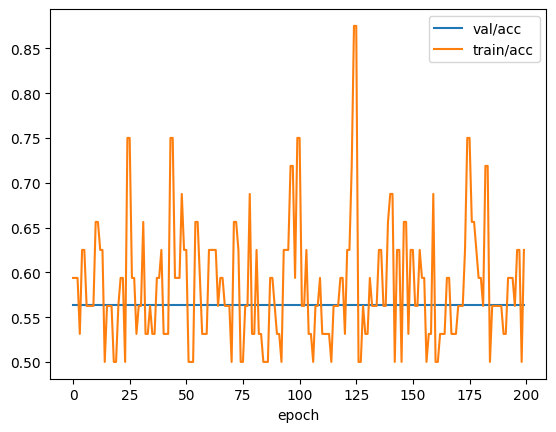

In [90]:
df_hist[['val/acc', 'train/acc']].plot()

df_hist[['val/f1', 'train/f1']].plot()

df_hist[['val/loss', 'train/loss']].plot()